In [1]:
%matplotlib inline
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def extract_demographics(root):
    p_data = {}

    # Get the device source and activity type
    source = root.find(".//SOURCE")
    p_data["Activity"] = source.get("TYPE")
    p_data["Model"] = source.get("MODEL")

    # Get the site number and ECG metadata + aquisition time
    site = root.find(".//SITE")
    if site is not None:
        p_data["Site Number:"] = site.get("ID")

    p_data["Acquisition Time"] = root.attrib["ACQUISITION_TIME"]
    p_data["QRS Count"] = root.attrib["NUM_QRS"]
    p_data["Average RR"] = root.attrib["AVERAGE_RR"]
    p_data["Heart Rate"] = 60000 / int(p_data["Average RR"])

    for demo in root.findall(".//DEMOGRAPHIC_FIELD"):
        label = demo.get("LABEL")
        value = demo.get("VALUE")

        if label in ["Site Number:", "Participant #:", "Age:", "Gender:", "ID:&ID:", "Age:&", "Sex:"]:
            p_data[label] = value

    return p_data

In [3]:
p_demographics = []

mort_path = Path("/media/nvme1/pbecg-data/mortara")
for file_path in mort_path.rglob("*xml"):
    tree = ET.parse(file_path)
    root = tree.getroot()
    p_data = extract_demographics(root)
    p_demographics.append(p_data)

In [4]:
# Rename keys in list of dictionary
for p_demo in p_demographics:
    age_keys = ["Age:&", "Age:"]
    for key in age_keys:
        if key in p_demo:
            p_demo["Age"] = p_demo.pop(key)
    
    id_keys = ["ID:&ID:", "Participant #:"]
    for key in id_keys:
        if key in p_demo:
            p_demo["ID"] = p_demo.pop(key)

    sex_keys = ["Sex:", "Gender:"]
    for key in sex_keys:
        if key in p_demo:
            p_demo["Sex"] = p_demo.pop(key)

    if "Site Number:" in p_demo:
        p_demo["Site Number"] = p_demo.pop("Site Number:")

In [5]:
demo_df = pd.DataFrame(p_demographics).drop_duplicates()
demo_df.shape

(3825, 10)

In [6]:
unique_ids = demo_df["ID"].unique()
print(f"Number of unique patients in Mortara files: {len(unique_ids)}")

Number of unique patients in Mortara files: 2486


In [7]:
demo_df["Age"] = pd.to_numeric(demo_df["Age"])
demo_df["Acquisition Time"] = pd.to_datetime(demo_df["Acquisition Time"], format="%Y%m%d%H%M%S")
demo_df["QRS Count"] = pd.to_numeric(demo_df["QRS Count"])
demo_df["Average RR"] = pd.to_numeric(demo_df["Average RR"])
demo_df.info()

demo_df.to_csv("/media/nvme1/pbecg-data/metadata.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 3825 entries, 0 to 4607
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Activity          3825 non-null   object        
 1   Model             3825 non-null   object        
 2   Acquisition Time  3825 non-null   datetime64[ns]
 3   QRS Count         3825 non-null   int64         
 4   Average RR        3825 non-null   int64         
 5   Heart Rate        3825 non-null   float64       
 6   Age               3825 non-null   int64         
 7   ID                3825 non-null   object        
 8   Sex               3825 non-null   object        
 9   Site Number       3825 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 328.7+ KB


## Some Exploratory Analysis

In [8]:
demo_df.head()

,Activity,Model,Acquisition Time,QRS Count,Average RR,Heart Rate,Age,ID,Sex,Site Number
0,RESTING,el150/250,2018-01-23 14:23:09,13,779,77.021823,40,7395625925,Female,62
1,RESTING,el150/250,2018-01-24 10:39:39,7,1308,45.871560,55,9998054694,Male,008
2,RESTING,el150/250,2018-01-23 11:48:37,10,915,65.573770,58,4017667892,Female,009
3,RESTING,el150/250,2017-12-14 13:09:59,11,885,67.796610,70,5212080063,Male,62
4,RESTING,el150/250,2018-02-06 12:13:49,14,673,89.153046,29,4654705937,Male,62


Text(0, 0.5, 'Count')

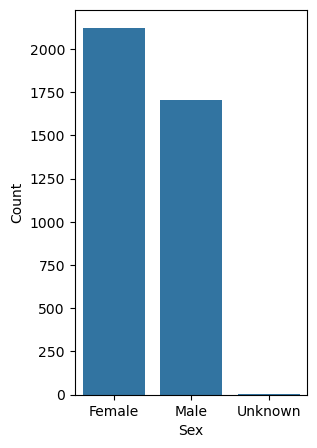

In [9]:
plt.figure(figsize=(3, 5))
sex_count = demo_df["Sex"].value_counts()
sns.barplot(x=sex_count.index, y=sex_count.values)
plt.ylabel("Count")

<Axes: xlabel='Age', ylabel='Count'>

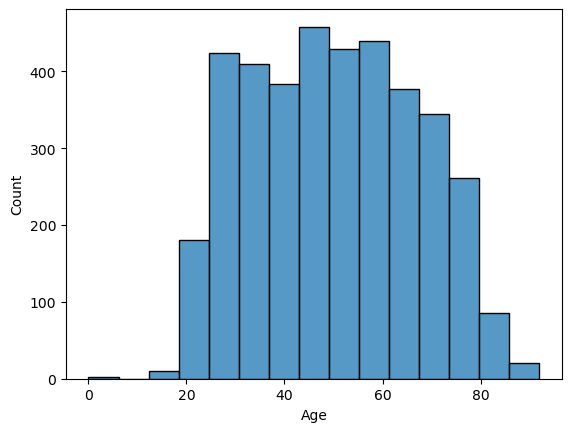

In [10]:
sns.histplot(demo_df[demo_df["Age"] < 100]["Age"], bins=15)

<Axes: xlabel='QRS Count', ylabel='Count'>

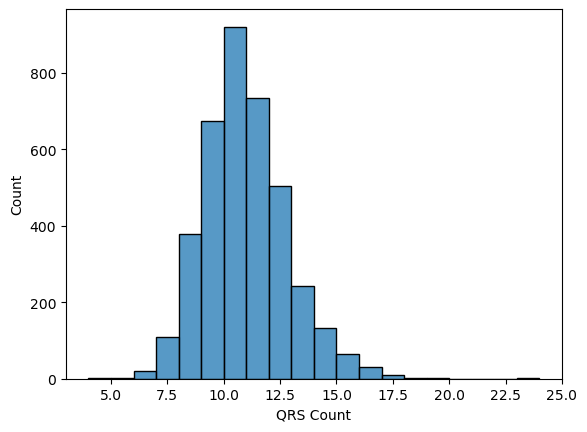

In [11]:
sns.histplot(demo_df["QRS Count"], bins=20)

<Axes: xlabel='Heart Rate', ylabel='Count'>

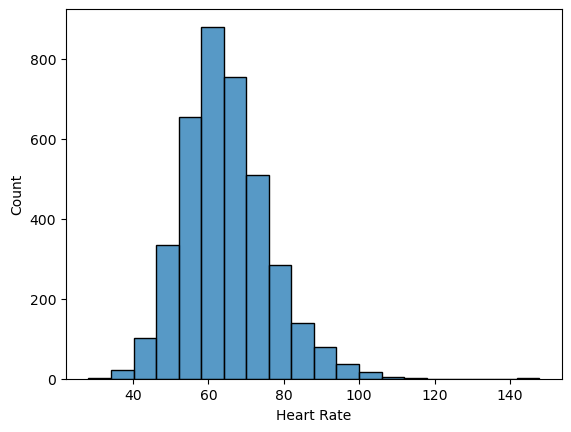

In [12]:
sns.histplot(demo_df["Heart Rate"], bins=20)